## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
src_path = '/home/dmi/src/'
sys.path.append(src_path)
import os
import pathlib
import numpy as np
import nibabel as nib
import sys
from data import utils
from nibabel.testing import data_path
import ImageViewer3D as I3D
import infer

import argparse
import glob
import imp
import subprocess
import yaml

import seaborn as sns
import pandas as pd

import chainer
import chainer.functions as F
import cv2 as cv
from chainer import Variable
from chainer import serializers
import os
import sys
import pathlib
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
sys.path.append('/home/dmi/src')
import dataset
import transforms
import losses
import metrics
import trainer

%cd /home/dmi/
from src import models
%cd /home/dmi/tganv1/tgan-master

/home/dmi
/home/dmi/tganv1/tgan-master


## Set up .npy files from cropped 64x64 images

In [12]:
all_paths = utils.get_paths_to_patient_files('/hecktor_nii_cropped/')
cr_imgs = np.empty([64,201,64,64])
cr_masks = np.empty([64,201,64,64])

for i in range(len(all_paths)):
    ct_gtvt = nib.load(all_paths[i][1])
    pt = nib.load(all_paths[i][0])
    
    cr_imgs[:,i,:,:] = np.transpose(pt.get_fdata(),[2,0,1])
    cr_masks[:,i,:,:] = np.transpose(ct_gtvt.get_fdata(),[2,0,1])

mx = np.max(cr_imgs)
mn = np.min(cr_imgs)
cr_imgs = (cr_imgs - mn)/(mx-mn)*255
cr_imgs = cr_imgs.astype('int')

np.save('cropped_imgs.npy',cr_imgs)
np.save('cropped_masks.npy',cr_masks)

## Set up 2-channel .npy for conditional TrGAN

In [14]:
noise = np.random.rand(64,201,64,64)*0.4
cr_masks = np.load('cropped_masks.npy')
cr_masks = (cr_masks+noise)*255/1.4

cr_imgs = np.load('cropped_imgs.npy')
cr_2ch = np.concatenate((np.expand_dims(cr_imgs,-1),np.expand_dims(cr_masks,-1)),axis=-1)
cr_2ch = cr_2ch.astype('int')
#cr_2ch is size (z,n,x,y,ch)
np.save('cropped_2ch_noise_0_4.npy',cr_2ch)

## View image with 3-D viewer

In [2]:
#Axial slices are along y-z direction
cr = np.load('cropped_2ch_noise_0_4.npy')
I3D.ImageSliceViewer3D(cr[:,0,:,:,0])

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

## Load the trained generator and generate images

### Unconditional images

In [3]:
np.random.seed(0)
chainer.cuda.cupy.random.seed(0)

result_dir ='' #Path to unconditional model directory

chainer.cuda.Device(0).use()

fsgen, vgen, _ = infer.get_models(result_dir, 28000) #Choose model iteration here
fsgen.to_gpu()
vgen.to_gpu()

z, _, _ = infer.make_video(fsgen, vgen, n=1)
z = z * 20 + 20


<ipython-input-2-e3697b0d1358>:81: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open(glob.glob('{}/*.yml'.format(result_dir))[0]))


variable([[-0.12309831]
          [-0.07927059]]) (1, 100, 1)
variable([[-0.01474876]
          [-0.06441099]]) (1, 1024, 1)


### Conditional images based on real masks

In [3]:
#Number of images to generate
n = 10

#Load real masks and images for comparison
#Limit size to 64x64x32
reals = np.transpose(cr,[2,3,0,1,4])[:,:,16:-16,:n,0] # (x,y,z,n)
masks = np.transpose(cr,[2,3,0,1,4])[:,:,16:-16,:n,1] # (x,y,z,n)
cr = np.transpose(np.expand_dims(cr[16:-16,:n,:,:,1]/255*2-1,axis=-1),[1,4,0,2,3]).astype('float32') #(n, 1, z, x, y)
cr = chainer.Variable(cr)

np.random.seed(0)
chainer.cuda.cupy.random.seed(0)

result_dir ='/home/dmi/tganv1/tgan-master/results/mnist_wgan_svd_zdim-100_no-beta-all_init-uniform-all_2022-05-07_17-20-03_0/'

chainer.cuda.Device(0).use()

fsgen, vgen, vdis = infer.get_models(result_dir, 33000) #Choose model iteration
fsgen.to_gpu()
vgen.to_gpu()
cr.to_gpu()

y, _, _ = infer.make_conditional_video(fsgen, vgen, n, cr)
y = y * 128 + 128

/home/dmi/tganv1/tgan-master/infer.py:100: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open(glob.glob('{}/*.yml'.format(result_dir))[0]))


## View the images

In [4]:
i=0
syn_img = np.transpose(y,[3,4,2,0,1])[:,:,:,i,0] #(x,y,z,N,1)
print('Subject',i)
I3D.ImageSliceViewer3D(np.transpose(y,[3,4,2,0,1])[:,:,:,i,0]) #(x,y,z,N,1)
print('Mask')
I3D.ImageSliceViewer3D(masks[:,:,:,i]*(masks[:,:,:,i]>120))
print('Real Image')
I3D.ImageSliceViewer3D(reals[:,:,:,i])

Subject 0


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Mask


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Real Image


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

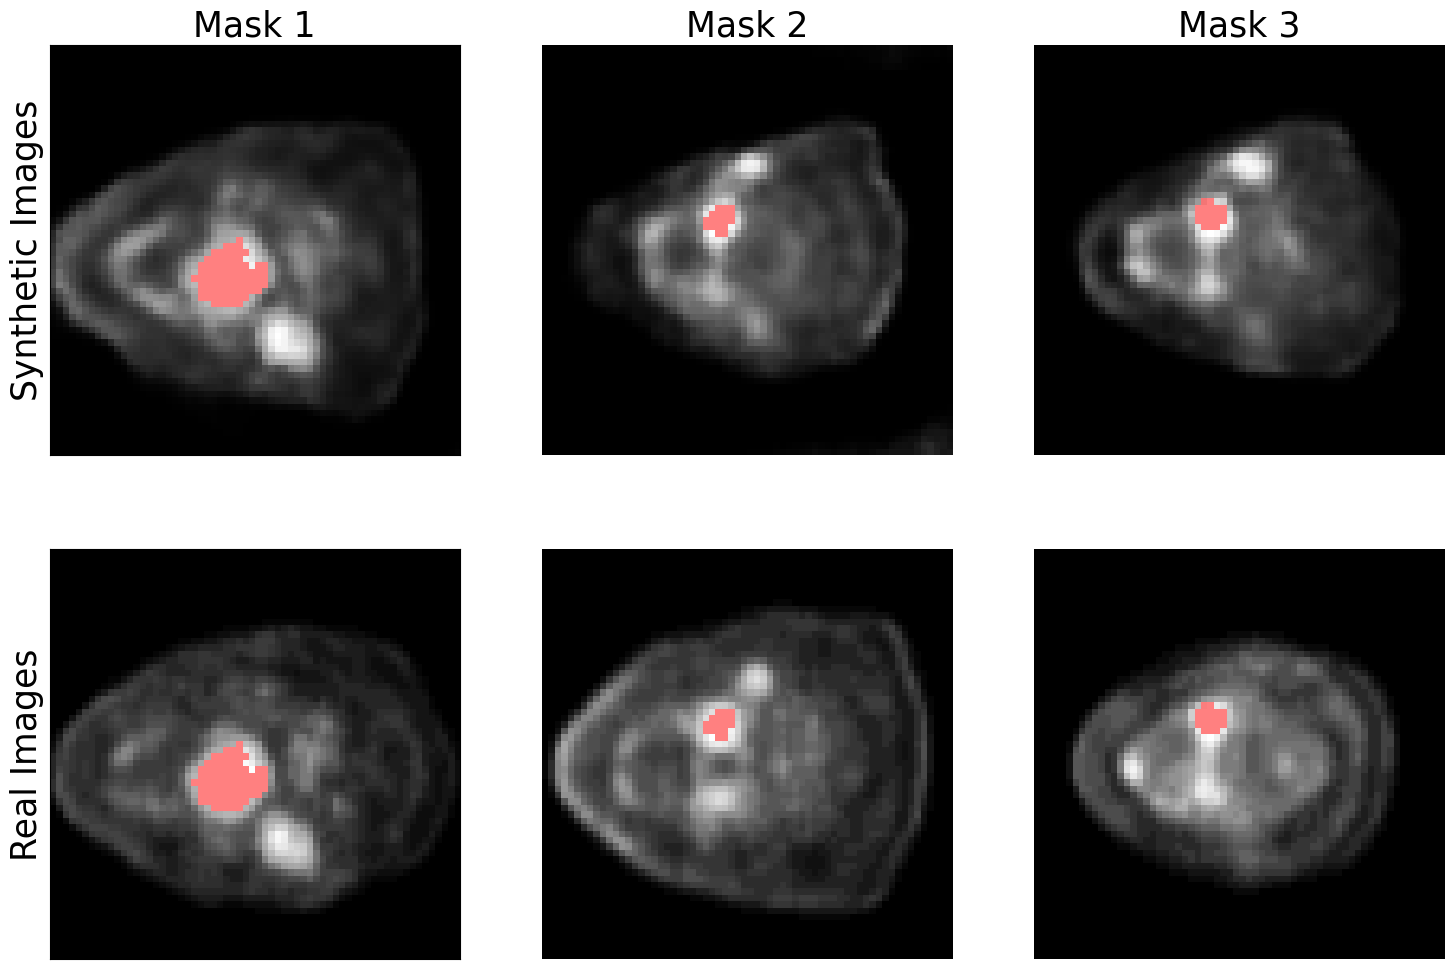

In [11]:
from copy import copy
plt.rcdefaults()
palette = copy(plt.cm.Greys_r)
palette.set_bad(color='r', alpha=1)  # set color for the mask
plt.figure(figsize=(18,12))
sl_list = [16, 20, 24]
sample_list = [0,1,2]

for i in range(3):
    syn_img = np.transpose(y,[3,4,2,0,1])[:,:,sl_list[i],sample_list[i],0]
    mask = (masks[:,:,sl_list[i],sample_list[i]]>100)
    syn_img_mask = np.ma.masked_where(syn_img * mask != 0, syn_img)

    real_img = (reals[:,:,sl_list[i],sample_list[i]])
    real_img_mask = np.ma.masked_where(real_img * mask != 0, real_img)


    plt.subplot(2,3,i+1)
    plt.imshow(syn_img,cmap=palette,interpolation='none',vmin=0,vmax=25)
    plt.imshow(syn_img_mask[:, :], cmap=palette, interpolation='none',alpha=0.5)
    plt.axis('off')
    if i < 3:
        plt.title('Mask '+str(i+1),fontsize=25)
    if i==0:
        plt.axis('on')
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        plt.ylabel('Synthetic Images',fontsize=25)
    plt.subplot(2,3,i+4)
    plt.axis('off')
    if i==0:
        plt.axis('on')
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        plt.ylabel('Real Images',fontsize=25)
    plt.imshow(real_img,cmap=palette,interpolation='none',vmin=0,vmax=25)
    plt.imshow(real_img_mask[:, :], cmap=palette, interpolation='none',alpha=0.5)
    

plt.show()

## Load the segmentation model

In [6]:
m = models.FastSmoothSENormDeepUNet_supervision_skip_no_drop(in_channels=1, n_cls=2, n_filters=24) #2,2,12 or 1,2,24
weights = torch.load('/home/dmi/hecktor_training_cropped_PETONLYv4/best_model_weights.pt')
m.load_state_dict(weights)

<All keys matched successfully>

## View example of segmentation

In [7]:
y_processed = np.transpose(np.pad(y,((0,0),(0,0),(16,16),(0,0),(0,0))),[0,1,3,4,2])

In [8]:
for i in range(np.shape(y_processed)[0]):
        y_processed[i,:,:,:,:] = (y_processed[i,:,:,:,:]-np.mean(y_processed[i,:,:,:,:]))/(np.std(y_processed[i,:,:,:,:])+1e-3)

with torch.no_grad():
        y_pred = m(torch.FloatTensor(y_processed)).cpu().detach().numpy()

y_pred = y_pred>0.5

In [10]:
j = 2 #choose random image

print('Synth Image')
I3D.ImageSliceViewer3D(y_processed[j,0,:,:,16:-16])

print('Synth Segmentation')
I3D.ImageSliceViewer3D(y_pred[j,0,:,:,16:-16])
real_masks = masks[:,:,:,:]*(masks[:,:,:,:]>120)
real_masks = np.pad(real_masks,((0,0),(0,0),(16,16),(0,0)),'constant')
real_masks=real_masks>0

print('Real Image')
I3D.ImageSliceViewer3D(reals[:,:,:,j])

print('Real Segmentation')
#Segmentation model requires 64 slices minimum so we'll pad here
test = np.expand_dims(np.transpose(np.pad(reals,((0,0),(0,0),(16,16),(0,0))),[3,0,1,2]),axis=1)
test = (test-np.mean(test))/(np.std(test)+1e-3)
with torch.no_grad():
    test = m(torch.FloatTensor(test)).cpu().detach().numpy()
test = test>0.5    
I3D.ImageSliceViewer3D(test[j,0,:,:,16:-16])

print('Real Label')
I3D.ImageSliceViewer3D(real_masks[:,:,16:-16,j])

Synth Image


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Synth Segmentation


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Real Image


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Real Segmentation


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Real Label


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…